In [382]:
import torch
import numpy as np
import torchvision.datasets as datasets
import torchvision
from tqdm import tqdm
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [383]:
# import a trained ResNet model for ILSVRC 2012
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# model  = resnet50(pretrained=True)

In [384]:
def normalize(image):
    norm = (image - image.mean())/image.std()
    norm = norm * 0.1
    norm = norm + 0.5
    norm = norm.clip(0, 1)
    return norm

In [385]:
# iterate over files in the Dataset Directory
imgs = [Image.open('Dataset/' + path) for path in os.listdir('Dataset')]

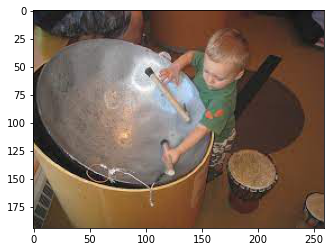

In [386]:
plt.imshow(imgs[0])
to_tensor = transforms.ToTensor()
data = [to_tensor(img) for img in imgs]

In [387]:
## Extract labels from file named 'imagenet_labels.txt'
labels = []
for line in open('imagenet_labels.txt'):
    labels.append(line.strip())

In [388]:
# Preprocess the image by making it a single batch of size 1 and passing it through the Resnet
unsqueeze = transforms.Lambda(lambda x: x.unsqueeze(0))
X = [unsqueeze(img) for img in data]
X[0].requires_grad = True # set the requires_grad attribute to True
op = model(X[0])
print(op.shape)

torch.Size([1, 1000])


In [389]:
# Get the index of the maximum value in the output vector
index = op.argmax().item()
print(index)
print(labels[index])

876
tub


In [390]:
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [391]:
# take gradient of the input  w.r.t the value of the argmax index
# op[0, index -1].retain_grad()
op[0, index].backward()
# print(op[0, index - 1].retain_grad())

In [392]:
# get the gradients wrt to input image 
grads = X[0].grad.data.numpy()

In [393]:
grads.shape

(1, 3, 194, 259)

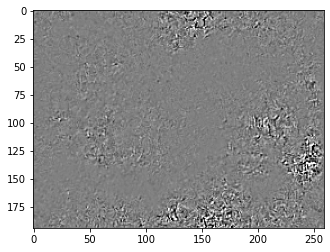

In [394]:
plt.imshow(normalize(grads[0,0,:,:]), cmap='gray')

### Guided Backpropagation 

To do this we need to set the gradients to zero wherever the gradients contribute negatively to the softmax probability 
of the predicted class

In [395]:
# defibne custom backward hook 

def backward_hook(module, grad_in, grad_out):
    if(isinstance(module, torch.nn.ReLU)):
        return (torch.clamp(grad_in[0], min=0.0),) # gradient clamped at negative values to zero

In [396]:
# set the hook to the model
def set_backward_hooks(model):
    for name, module in model.named_modules():
        if(isinstance(module, torch.nn.ReLU)):
            module.register_backward_hook(backward_hook)
            print("Backward Hooked", name)
            

In [397]:
feature_maps = []

In [398]:
def forward_hook(module, input, output):
    global feature_maps
    if(isinstance(module, torch.nn.modules.pooling.AdaptiveAvgPool2d)):
        feature_maps.append(input)
    return output

In [399]:
def set_forward_hooks(model):
    features = []
    for name, module in model.named_modules():
        if(isinstance(module, torch.nn.modules.pooling.AdaptiveAvgPool2d)):
            module.register_forward_hook(forward_hook)
            print("Forward Hooked", name)

In [400]:
set_backward_hooks(model)

Backward Hooked relu
Backward Hooked layer1.0.relu
Backward Hooked layer1.1.relu
Backward Hooked layer1.2.relu
Backward Hooked layer2.0.relu
Backward Hooked layer2.1.relu
Backward Hooked layer2.2.relu
Backward Hooked layer2.3.relu
Backward Hooked layer3.0.relu
Backward Hooked layer3.1.relu
Backward Hooked layer3.2.relu
Backward Hooked layer3.3.relu
Backward Hooked layer3.4.relu
Backward Hooked layer3.5.relu
Backward Hooked layer4.0.relu
Backward Hooked layer4.1.relu
Backward Hooked layer4.2.relu


In [401]:
set_forward_hooks(model)

Forward Hooked avgpool


In [402]:
model2 = model
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
optimizer.zero_grad()
X[0].grad.zero_()
op_same = model2(X[0])
op_same[0,index].backward()

/home/arkartik/anaconda3/envs/adaenv/lib/python3.9/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Text(0.5, 1.0, 'Notice the Tub shape being created')

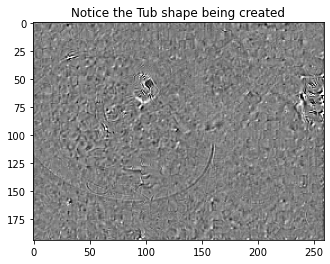

In [403]:
guided = X[0].grad.data.numpy()[0,0,:,:]
plt.imshow(normalize(X[0].grad.data.numpy()[0,0,:,:]), cmap = 'gray')
plt.title('Notice the Tub shape being created')

### Class Activation Maps

---

In order to make the class activation maps useful one must extract the layer weights and activations from the model

In [404]:
for name, module in model.named_modules():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.conv3
layer1.0.bn3
layer1.0.relu
layer1.0.downsample
layer1.0.downsample.0
layer1.0.downsample.1
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.conv3
layer1.1.bn3
layer1.1.relu
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.conv2
layer1.2.bn2
layer1.2.conv3
layer1.2.bn3
layer1.2.relu
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.conv3
layer2.0.bn3
layer2.0.relu
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer2.1.conv3
layer2.1.bn3
layer2.1.relu
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.conv2
layer2.2.bn2
layer2.2.conv3
layer2.2.bn3
layer2.2.relu
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.conv2
layer2.3.bn2
layer2.3.conv3
layer2.3.bn3
layer2.3.relu
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.conv

In [405]:
final_weights = model.fc.weight.data.numpy()
print(final_weights.shape)
print(X[0].shape)
print(feature_maps[0][0].shape)

(1000, 2048)
torch.Size([1, 3, 194, 259])
torch.Size([1, 2048, 7, 9])



$$
\begin{align}
    M_{x,y} &= \sum_{k=1}^{K} W_{c,k} \cdot A_{k,x,y} \\
    &= A_{x, y , :} \cdot \vec{W}_{c, :} \\
\end{align}
$$

In [406]:
def get_CAM(pre_pool_weight, final_weights, index, input_size):
    channels, height, width = pre_pool_weight.shape # 2048, 7, 9
    cam = np.zeros((height, width), dtype=np.float32)
    for i in range(channels):
        cam += pre_pool_weight[i, :, :] * final_weights[index, i] # matrix into scalar multiplication
    # now we must upsample the cam to the size of the input image
    cam = np.maximum(cam, 0) # ReLU can be done here
    return cv2.resize(cam, (input_size[1], input_size[0]))

    

In [407]:
X[0].shape

torch.Size([1, 3, 194, 259])

In [408]:
op = get_CAM(feature_maps[0][0].data.numpy()[0,:,:,:], final_weights, index, X[0].shape[2:])

In [409]:
op.shape
# now overlay the CAM with the input image
stacked_op  = np.stack((op,)*3, axis=-1)
stacked_op  = stacked_op.transpose(2,0,1)
# plt.imshow(stacked_op)
print(stacked_op.shape)
net_image = X[0].data.numpy()[0,:,:,:]*0.5 + 0.5*stacked_op
print(net_image.shape)

(3, 194, 259)
(3, 194, 259)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


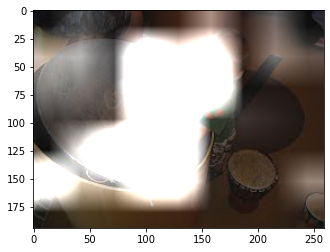

In [410]:
plt.imshow(net_image.transpose(1,2,0))

### Guided Gradient Weighted Class Activation Maps

First thing to note that since we are using an adaptive pooling layer, both CAM and GRADCAM will yield the same results
since the weights are equal to the gradients anyway. so using the weights and the graidients are equivalent
we need only take the hadamard product of both at the end and then visualize


(194, 259)
(3, 194, 259)


Text(0.5, 1.0, 'Guided Backpropagation')

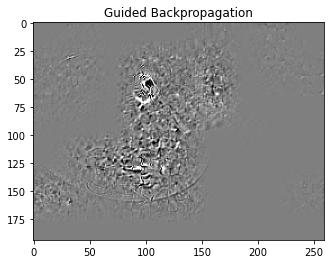

In [411]:
 # for this we must first note something important
print(guided.shape)
guided = np.stack((guided,)*3, axis=-1)
guided = guided.transpose(2,0,1)
print(stacked_op.shape)
net = guided * stacked_op
plt.imshow(normalize(net).transpose(1,2,0))
plt.title('Guided Grad CAM')